# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

# Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, make_column_selector, ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector,SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import category_encoders as ce
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import os
import import_ipynb
import CommonFunction as cf
import importlib
from sklearn import set_config
set_config(display="diagram")

warnings.filterwarnings('ignore')

importing Jupyter notebook from CommonFunction.ipynb


In [7]:
!pip install category_encoders
!pip install ipynb
!pip install import_ipynb


In [8]:
images_path = "./images/"
if not os.path.isdir(images_path):
    os.mkdir("./images") 

rs = 42
## Dealership Sales has steadly increased since 2001 and so using that starting index
sales_since = '2006-01-01'
figcounter = 0




In [9]:
used_cars_df = pd.read_csv('data/vehicles.csv')
used_cars_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [10]:
used_cars_df.head(5)


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc



#Simple function to dump the feature with percentages
def feature_null_percentage_in_data(df):
    print(round(df.isnull().sum()/df.shape[0] * 100,2))

def cleaned_data_percent(df):
    cleaned_df = df.dropna()
    print(((df.shape[0] - cleaned_df.shape[0])/df.shape[0])* 100)

def feature_selection_method(pipeline):
    pipeline.fit(X_train, y_train)
    train_mse = mean_squared_error(y_train, pipeline.predict(X_train))
    print('train_mse : ' , train_mse)
    test_mse = mean_squared_error(y_test, pipeline.predict(X_test))
    print('test_mse : ', test_mse)
    score = pipeline.score(X_test, y_test)
    print(score)
    model_coefs = pipeline.named_steps['ridge'].coef_
    feature_names = pipeline.named_steps['selector'].get_feature_names_out()
    print(model_coefs)
    print(feature_names)
    return pd.DataFrame(({'feature' : feature_names, 'coef': model_coefs}))

def getFigTitle(fig, title):
    fig = fig + 1
    return f'Fig{ fig} : {title}', fig

def valuecount_percentages(feature_series):
    vc_series = feature_series.value_counts()
    print('Name             Counts          Percents')
    for item in vc_series.index:
        print(f"{item:<15}  "
        f"{vc_series[item]:<15} "
        f"{(vc_series[item]/feature_series.size) * 100:.3f}")
    percentage_series = feature_series.value_counts(normalize=True).mul(100).round(1)


## Data Exploration

#### First level feature selection to see which features have 30% or more nulls and maybe candidates be dropped, since it becomes difficult to fill that data. But will still using ffill() anf bfill() since we want to keep as much data and features. Not sure if this data can cause bad MSE or poor score

In [14]:
#Lets check the percentage of nulls in data 
cf.feature_null_percentage_in_data(used_cars_df)


id               0.00
region           0.00
price            0.00
year             0.28
manufacturer     4.13
model            1.24
condition       40.79
cylinders       41.62
fuel             0.71
odometer         1.03
title_status     1.93
transmission     0.60
VIN             37.73
drive           30.59
size            71.77
type            21.75
paint_color     30.50
state            0.00
dtype: float64


In [15]:
cf.valuecount_percentages(used_cars_df.cylinders)

Name             Counts          Percents
6 cylinders      94169           22.060
4 cylinders      77642           18.188
8 cylinders      72062           16.881
5 cylinders      1712            0.401
10 cylinders     1455            0.341
other            1298            0.304
3 cylinders      655             0.153
12 cylinders     209             0.049


In [16]:
# Check for percentage of null across dataset
cf.feature_null_percentage_in_data(used_cars_df)

id               0.00
region           0.00
price            0.00
year             0.28
manufacturer     4.13
model            1.24
condition       40.79
cylinders       41.62
fuel             0.71
odometer         1.03
title_status     1.93
transmission     0.60
VIN             37.73
drive           30.59
size            71.77
type            21.75
paint_color     30.50
state            0.00
dtype: float64


In [17]:
used_cars_df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [18]:
#Based on above - we can drop column size since it is has 71% missing
used_cars_df.drop(columns=['size'], inplace=True)

# Also feature ID, VIN can be dropped since they are unique values
used_cars_df.drop(columns=['VIN', 'id'],inplace=True)

# WHat is the percentage of data we will loose if we drop all NaN's
cf.cleaned_data_percent(used_cars_df)
# We lose 72% of dataset. Don't think that is acceptable in the model

72.82889805097452


In [19]:
# Lets drop columns condition, since condition of a car is hard to predict
# Drive does not add any value 
#used_cars_df.drop(columns=['condition','drive'], inplace=True)
used_cars_df.drop(columns=['condition'], inplace=True)

In [20]:
cf.feature_null_percentage_in_data(used_cars_df)

region           0.00
price            0.00
year             0.28
manufacturer     4.13
model            1.24
cylinders       41.62
fuel             0.71
odometer         1.03
title_status     1.93
transmission     0.60
drive           30.59
type            21.75
paint_color     30.50
state            0.00
dtype: float64


In [21]:
# Paint color is normally a important feature in car buying and dropping rows with 30% NaN's it too much. 
# In US in general white is most popular color of choice in car selection  
used_cars_df.paint_color.unique()

array([nan, 'white', 'blue', 'red', 'black', 'silver', 'grey', 'brown',
       'yellow', 'orange', 'green', 'custom', 'purple'], dtype=object)

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [23]:
### Lets do some data preparation to fill by grouping car based on manufacturer and model
used_cars_df.paint_color = used_cars_df.groupby(['manufacturer','model'])['paint_color'].fillna(method='ffill')
used_cars_df.paint_color = used_cars_df.groupby(['manufacturer','model'])['paint_color'].fillna(method='bfill')
used_cars_df.type = used_cars_df.groupby(['manufacturer','model'])['type'].fillna(method='ffill')
used_cars_df.type = used_cars_df.groupby(['manufacturer','model'])['type'].fillna(method='bfill')
used_cars_df.cylinders = used_cars_df.groupby(['manufacturer','model'])['cylinders'].fillna(method='ffill')
used_cars_df.cylinders = used_cars_df.groupby(['manufacturer','model'])['cylinders'].fillna(method='bfill')
used_cars_df.drive = used_cars_df.groupby(['manufacturer','model'])['drive'].fillna(method='ffill')
used_cars_df.drive = used_cars_df.groupby(['manufacturer','model'])['drive'].fillna(method='bfill')


In [24]:
# Lets validate the null percentages again
cf.feature_null_percentage_in_data(used_cars_df)

region          0.00
price           0.00
year            0.28
manufacturer    4.13
model           1.24
cylinders       6.02
fuel            0.71
odometer        1.03
title_status    1.93
transmission    0.60
drive           5.75
type            5.50
paint_color     5.63
state           0.00
dtype: float64


In [25]:
# Now we down to single digits in, so lets check what is the percentaage of data we will lose when we do drop 
cf.cleaned_data_percent(used_cars_df)

9.66758808095952


In [26]:
#It is 9%, which we can lose now, so lets go ahead and drop it
used_cars_df.dropna(inplace=True)

In [27]:
#Lets do a data check again if it clean or not
cf.feature_null_percentage_in_data(used_cars_df)

region          0.0
price           0.0
year            0.0
manufacturer    0.0
model           0.0
cylinders       0.0
fuel            0.0
odometer        0.0
title_status    0.0
transmission    0.0
drive           0.0
type            0.0
paint_color     0.0
state           0.0
dtype: float64


### Lets perform some data correlation, based on counts and get an understanding what sells at the dealership's and we can draw some anlaysis of data
- manufacturer
- cyclinders
- type
- paint_color
- fuel type
- title 

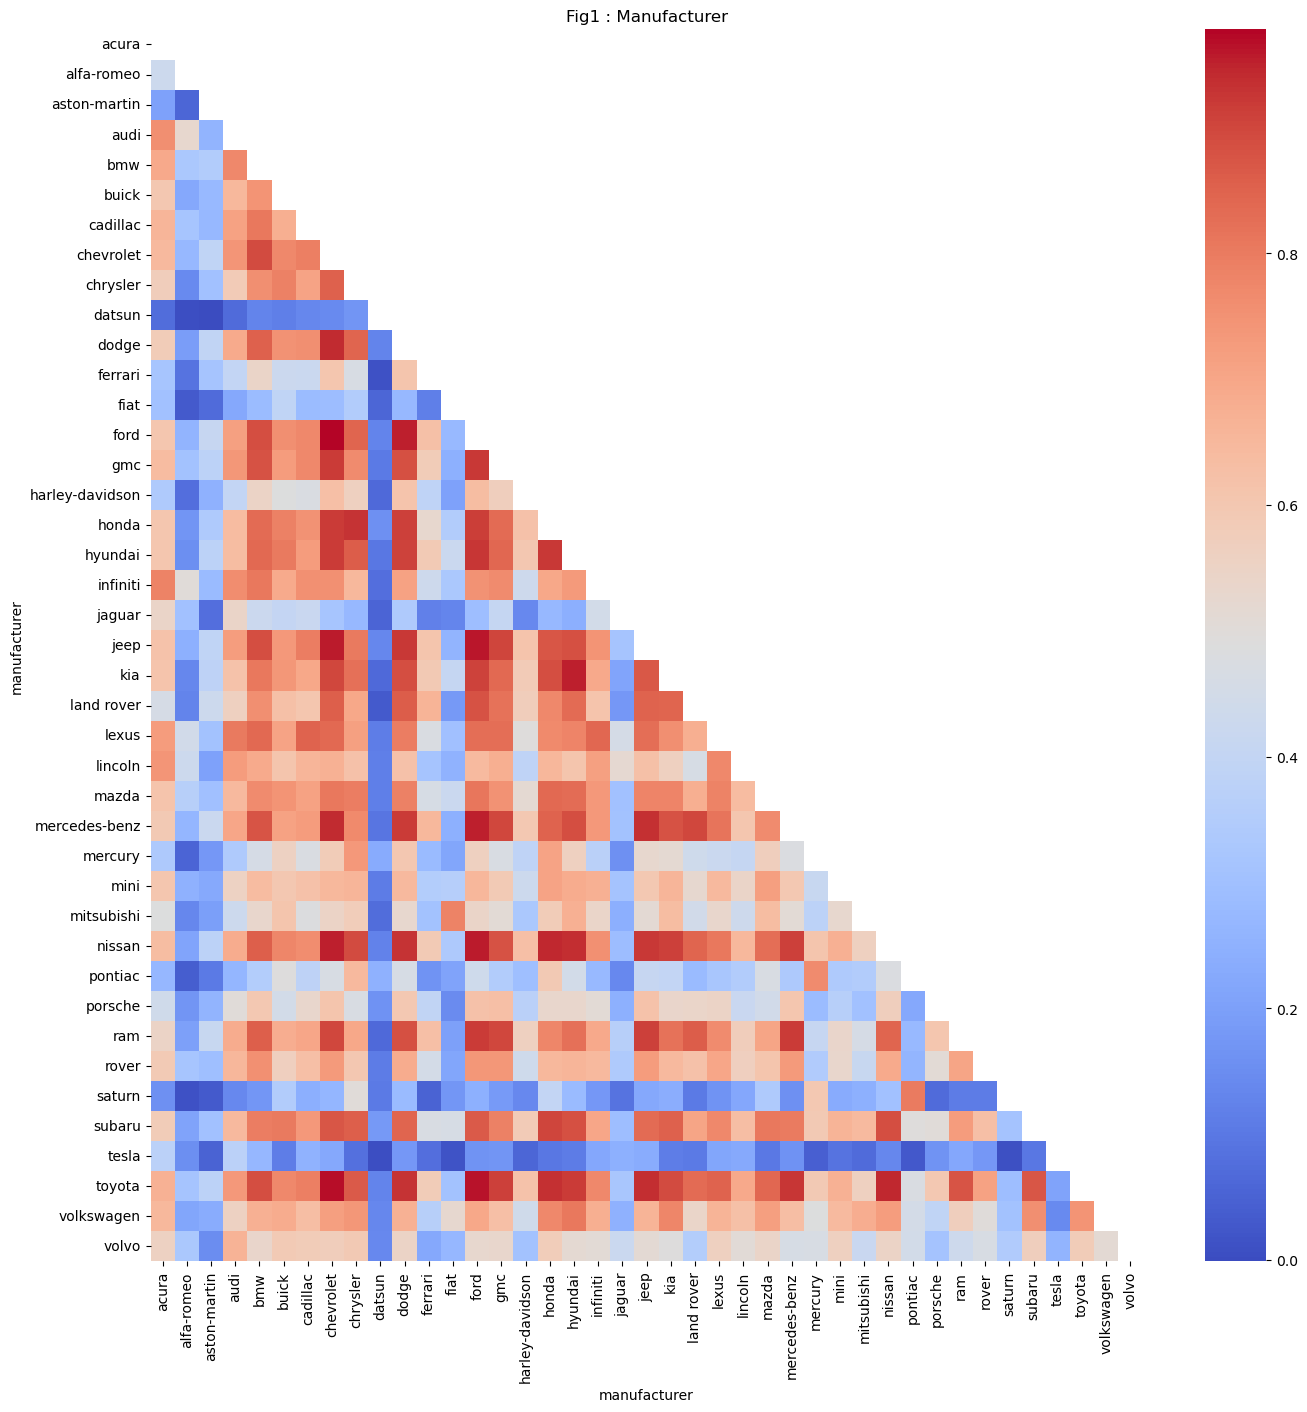

In [29]:
# Lets perform some data correlation, based on counts and get an understanding what sells

# Which manufacturer has correlation to sales
plt.figure(figsize=(16,16))
corr_data = pd.crosstab(used_cars_df.price, used_cars_df.manufacturer).corr()
matrix = np.triu(corr_data)
sns.heatmap(corr_data, cmap= 'coolwarm', mask=matrix)
title, figcounter = cf.getFigTitle(figcounter, 'Manufacturer')
plt.title(title)
plt.savefig(images_path+title)
plt.show()

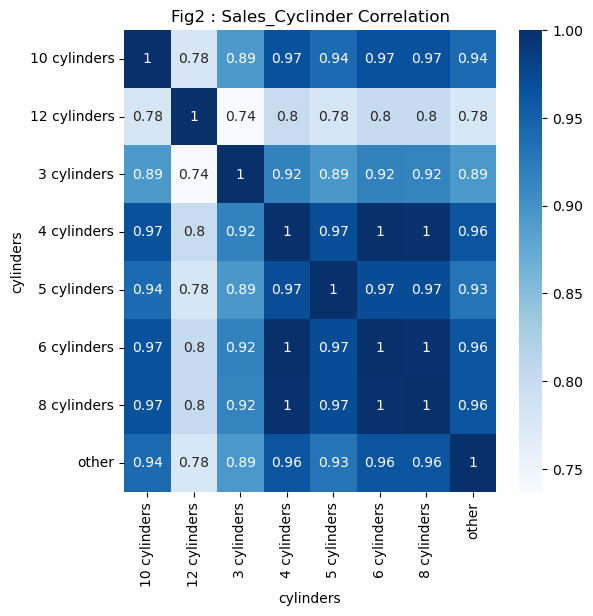

In [30]:
plt.figure(figsize=(6,6))
corr_data_cycinder_sales = pd.crosstab(used_cars_df.price, used_cars_df.cylinders.sort_values()).corr()
#matrix = np.triu(corr_data)
sns.heatmap(corr_data_cycinder_sales, annot=True, cmap= 'Blues')
title, figcounter = cf.getFigTitle(figcounter, 'Sales_Cyclinder Correlation')
plt.title(title)
plt.savefig(images_path+title)
plt.show()

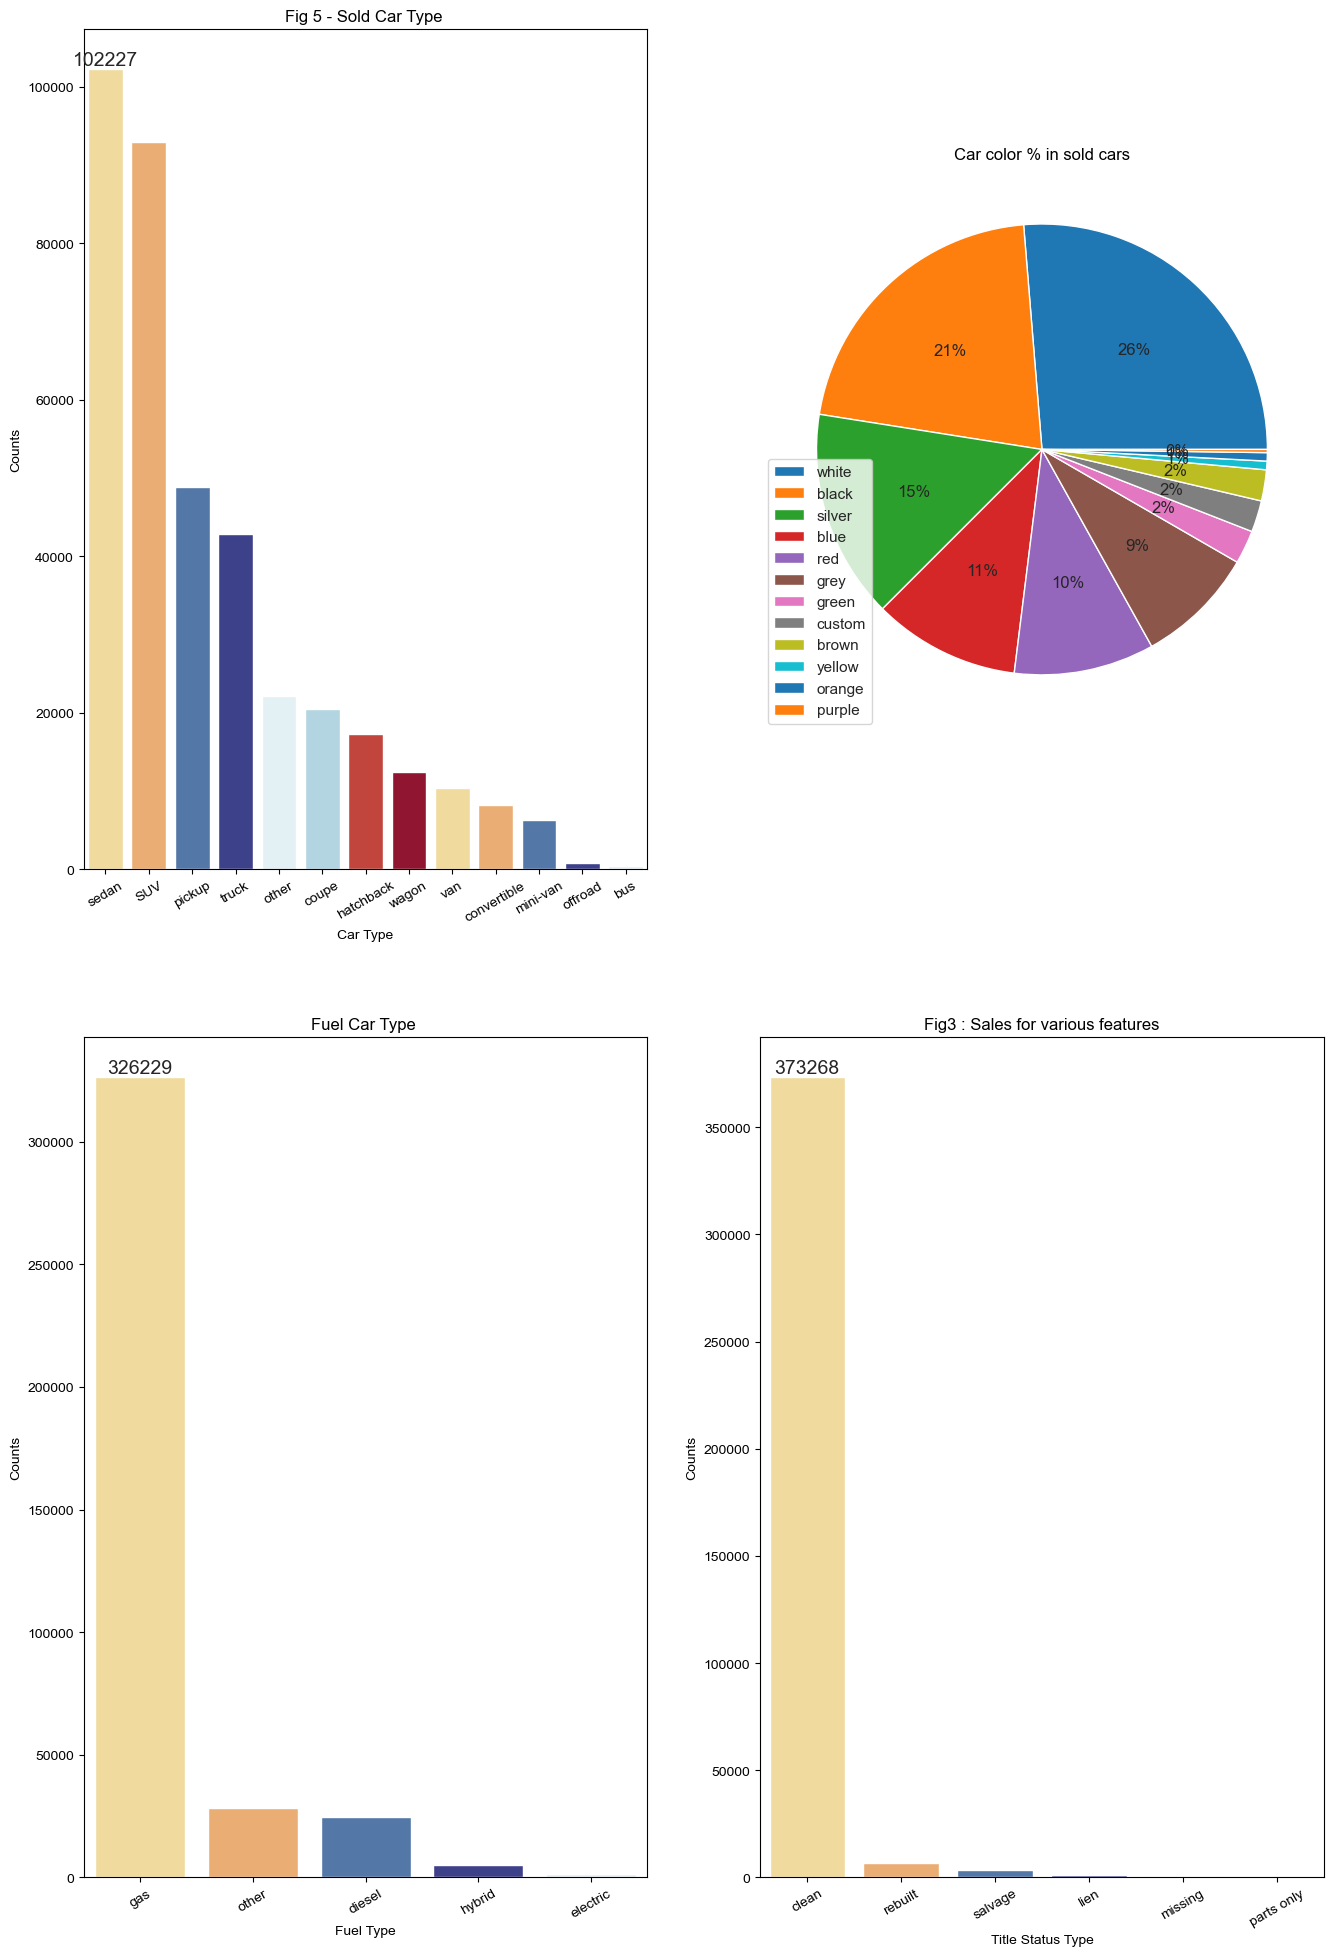

In [31]:
# Plot some bunch of features
palette = ["#fee090", "#fdae61", "#4575b4", "#313695", "#e0f3f8", "#abd9e9", "#d73027", "#a50026"]

fig, axs = plt.subplots(2, 2)
fig.set_figheight(24)
fig.set_figwidth(16)
type_df = used_cars_df.type.value_counts().to_frame().reset_index()
sns.set_theme(style="whitegrid")
sns.barplot(type_df, x='type', y='count', ax=axs[0,0], palette=palette)
axs[0,0].bar_label(axs[0,0].containers[0], fontsize=14);
axs[0,0].set_xlabel("Car Type")
axs[0,0].tick_params(axis='x', rotation=30)
axs[0,0].set_ylabel("Counts")
axs[0,0].set_title('Fig 5 - Sold Car Type ') 

paint_colors_counts = used_cars_df.paint_color.value_counts()
axs[0,1].pie(paint_colors_counts, autopct='%1.0f%%')    
axs[0,1].legend(labels=paint_colors_counts.index)
axs[0,1].set_title('Car color % in sold cars')

fuel_df = used_cars_df.fuel.value_counts().to_frame().reset_index()
sns.set_theme(style="whitegrid")
sns.barplot(fuel_df, x='fuel', y='count', ax=axs[1,0], palette=palette)
axs[1,0].bar_label(axs[1,0].containers[0], fontsize=14);
axs[1,0].set_xlabel("Fuel Type")
axs[1,0].tick_params(axis='x', rotation=30)
axs[1,0].set_ylabel("Counts")
axs[1,0].set_title('Fuel Car Type ') 

title_status_df = used_cars_df.title_status.value_counts().to_frame().reset_index()
sns.set_theme(style="whitegrid")
sns.barplot(title_status_df, x='title_status', y='count', ax=axs[1,1], palette=palette)
axs[1,1].bar_label(axs[1,1].containers[0], fontsize=14);
axs[1,1].set_xlabel("Title Status Type")
axs[1,1].tick_params(axis='x', rotation=30)
axs[1,1].set_ylabel("Counts")
axs[1,1].set_title('Car Title Status Counts') 

title, figcounter = cf.getFigTitle(figcounter, 'Sales for various features')
plt.title(title)
plt.savefig(images_path+title)

plt.show()


#df_color.count
#plt.barh(df_color.index, df_color.count)
#df_type = used_cars_df.type.value_counts()
#axs[1].bar(df_type.index, df_type.count)


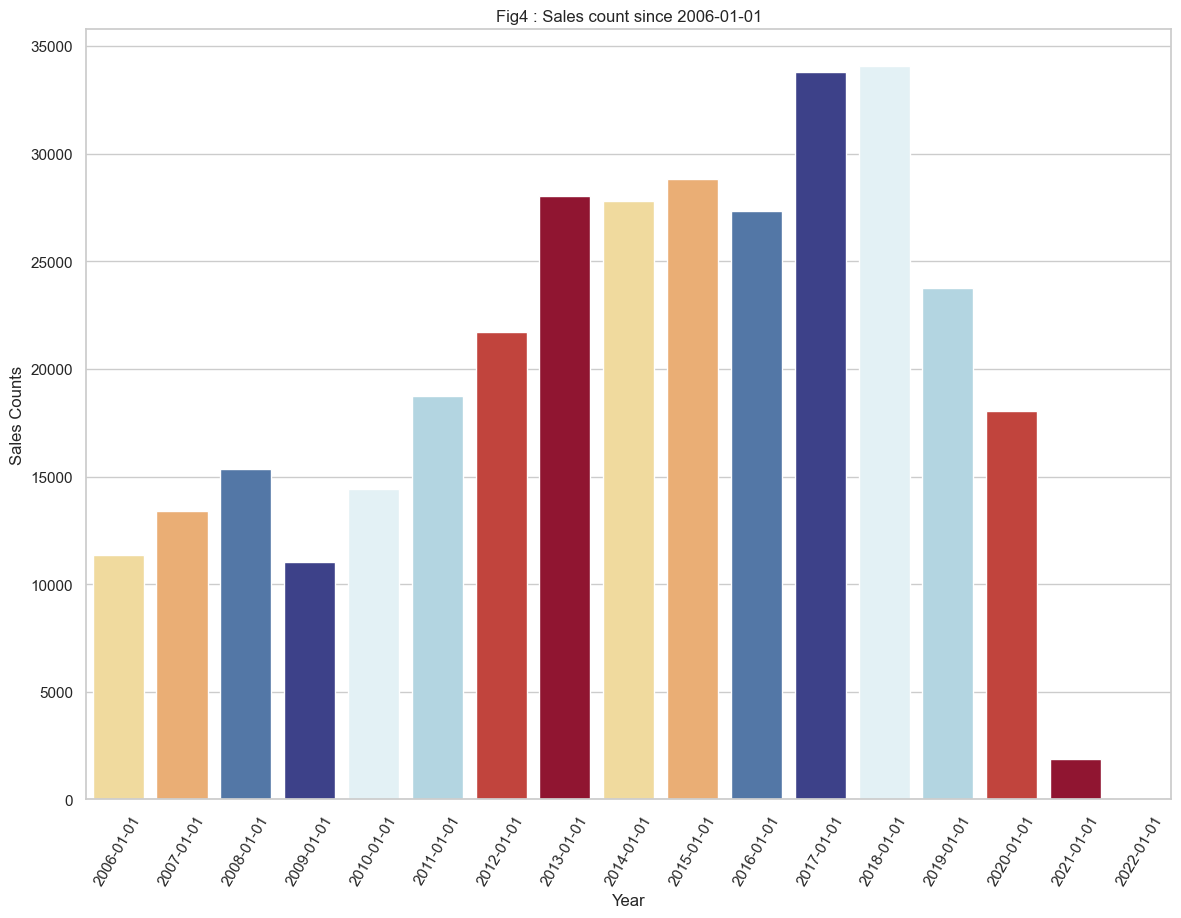

In [32]:
# Car sales based on years
plt.figure(figsize=(14,10))
year_df = used_cars_df.year.value_counts().to_frame().reset_index()
year_df.index = pd.to_datetime(year_df.year, format='%Y')
year_df = year_df.drop('year', axis=1)
sliced_year_df = year_df[sales_since:]
sliced_year_df.sort_index(inplace=True)
sns.set_theme(style="whitegrid")
sns.barplot(sliced_year_df.reset_index(), x='year', y='count', palette=palette)
#sns.barplot(x=year_df.count, y=year_df.year,  orient='h')

#plt.bar_label(year_df.year, fontsize=14);
plt.xlabel('Year')
plt.xticks(rotation=60)
plt.ylabel("Sales Counts")
title, figcounter = cf.getFigTitle(figcounter, f'Sales count since {sales_since}')
plt.title(title)
plt.savefig(images_path+title)
plt.show()


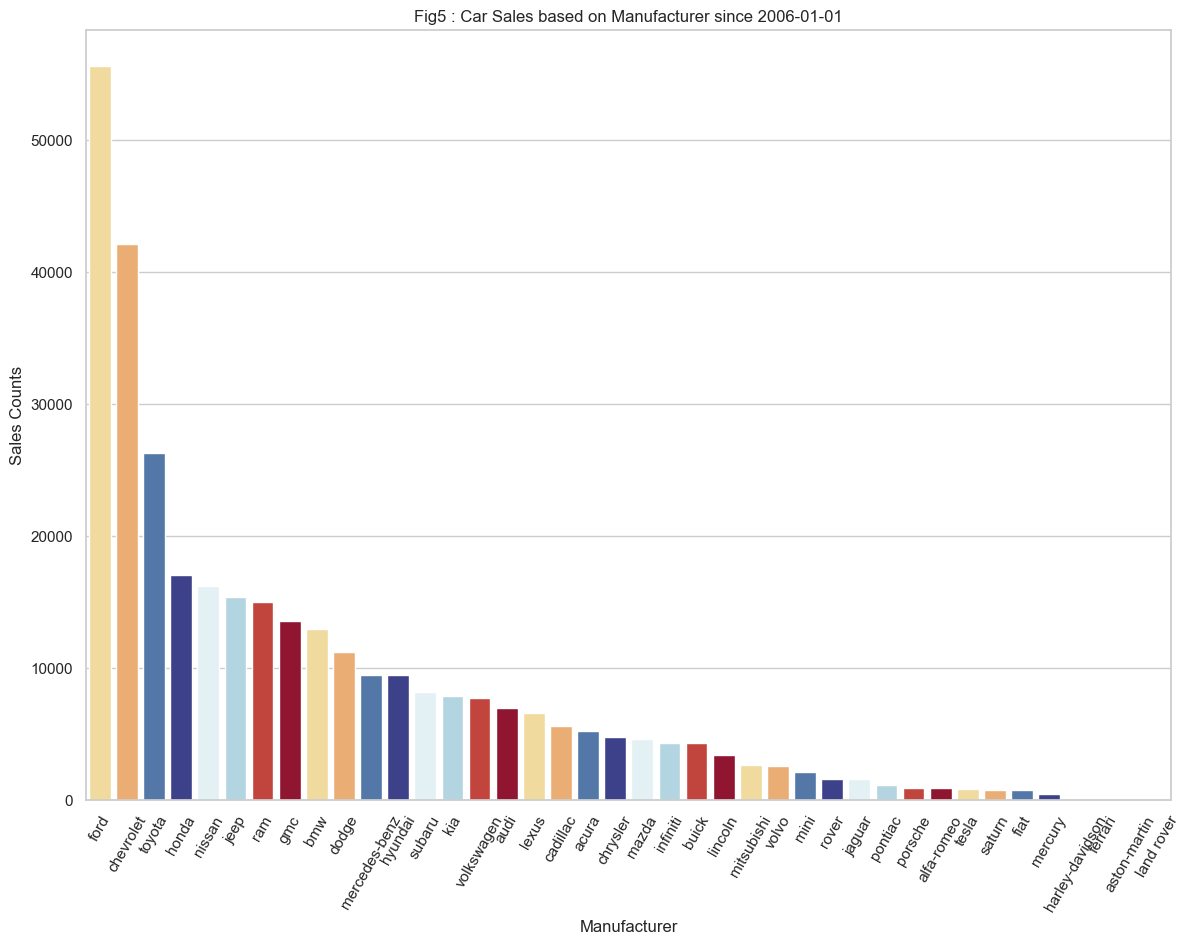

In [33]:
# Maufacturer's
plt.figure(figsize=(14,10))
manu_df = used_cars_df.reset_index()
manu_df.index = pd.to_datetime(manu_df.year, format='%Y')
sliced_year_df = manu_df[sales_since:]
manufacturer_df = sliced_year_df.manufacturer.value_counts().to_frame().reset_index()

manufacturer_df.sort_index(inplace=True)
sns.set_theme(style="whitegrid")
sns.barplot(manufacturer_df, x='manufacturer', y='count', palette=palette)
#sns.barplot(x=year_df.count, y=year_df.year,  orient='h')

#plt.bar_label(year_df.year, fontsize=14);
plt.xlabel('Manufacturer')
plt.xticks(rotation=60)
plt.ylabel("Sales Counts")

title, figcounter = cf.getFigTitle(figcounter, f'Car Sales based on Manufacturer since {sales_since}')
plt.title(title)
plt.savefig(images_path+title)
plt.show()


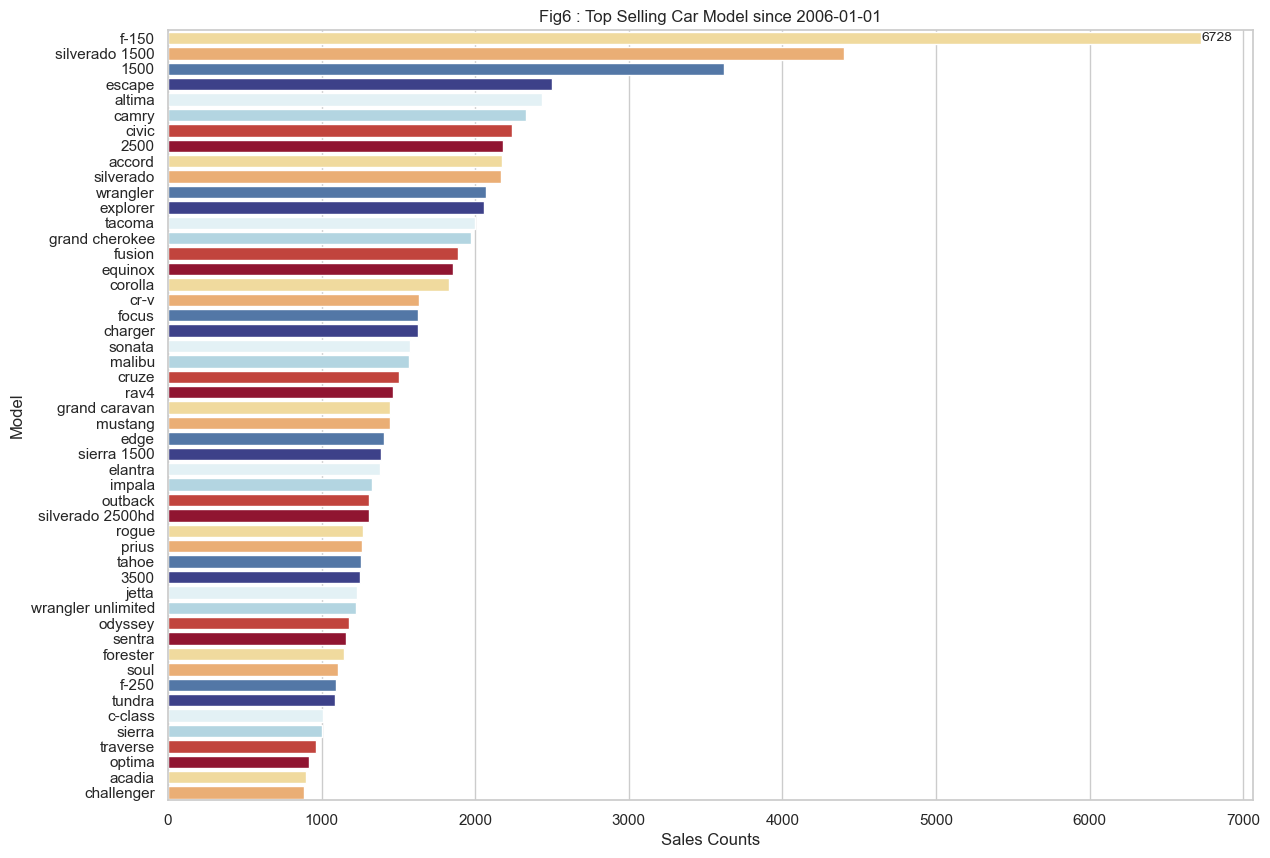

In [34]:
# Car models
plt.figure(figsize=(14,10))
model_df = used_cars_df.reset_index()
model_df.index = pd.to_datetime(manu_df.year, format='%Y')
model_sliced_df = model_df[sales_since:].model.value_counts().to_frame().reset_index()[:50]

model_sliced_df.sort_index(inplace=True)
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=model_sliced_df, y='model', x='count',  palette=palette)
ax.bar_label(ax.containers[0], fontsize=10);
plt.xlabel("Sales Counts")
plt.ylabel("Model")
title, figcounter = cf.getFigTitle(figcounter, f'Top Selling Car Model since {sales_since}')
plt.title(title)
plt.savefig(images_path+title)
plt.show()


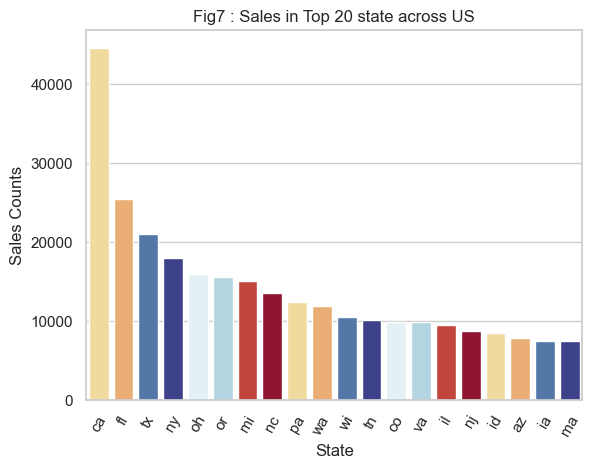

In [35]:
# Breakdown by top 20 states
number_states_to_show = 20
state_df = used_cars_df.state.value_counts().to_frame().reset_index()
sns.set_theme(style="whitegrid")
sns.barplot(state_df[:number_states_to_show], x='state', y='count', palette=palette)
plt.xlabel('State')
plt.xticks(rotation=60)
plt.ylabel("Sales Counts")
title, figcounter = cf.getFigTitle(figcounter,f'Sales in Top {number_states_to_show} state across US')
plt.title(title)
plt.savefig(images_path+title)

plt.show()


In [36]:
# The region feature has too 404 uniques values which will add complexity to model so it can be dropped for now
# Also the  model which can be important feature has 21769 unique values, so will drop for now

used_cars_df.drop(columns=['region'], inplace=True)

In [37]:
used_cars_df.head()

,price,year,manufacturer,model,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
27,33590,2014.0,gmc,sierra 1500 crew cab slt,4 cylinders,gas,57923.0,clean,other,4wd,SUV,blue,al
28,22590,2010.0,chevrolet,silverado 1500,6 cylinders,gas,71229.0,clean,other,rwd,truck,white,al
29,39590,2020.0,chevrolet,silverado 1500 crew,4 cylinders,gas,19160.0,clean,other,fwd,sedan,white,al
30,30990,2017.0,toyota,tundra double cab sr,6 cylinders,gas,41124.0,clean,other,fwd,SUV,white,al
31,15000,2013.0,ford,f-150 xlt,8 cylinders,gas,128000.0,clean,automatic,4wd,truck,black,al


#### What type of encoding should be used for all the categorical data, choices are
- OnehotEncoder
- OrdinalEncoder
- CountEncoder

Based on the dataset want to preserve the count frequency for predicting sales price, since certain type of cars sells a whole lot, So trying with <b>CountEncoder</b>. OneHotEncoder will increase the cardinality of the dataset since the categorical columns have lot of unique values for Manufacturer. Model has 22K plus unique, so dropped that feature. 

NOTE: The other choice of encoder could be OrdinalEncoder that should help in controlling cardinality of data. Maybe for future eval
  

In [39]:
#Since we using for the first time we test is before adding to pipelines for running multiple models
# Will be using Count Encoder, instead of OneHotEncoder 

# We are close to 385 K records
model_df = used_cars_df.reset_index()
model_df.index = pd.to_datetime(manu_df.year, format='%Y')
used_car_sliced_by_date_df = model_df[sales_since:]
used_car_sliced_by_date_df.index = used_car_sliced_by_date_df['index']
used_car_sliced_by_date_df.drop(columns='index', inplace=True)
used_car_sliced_by_date_df

#The function encodes/transformers and scales the data
used_cars_encoded_df = cf.count_encoder(used_car_sliced_by_date_df, cf.get_cat_features(used_car_sliced_by_date_df))

In [40]:
print(used_car_sliced_by_date_df.shape)
print(used_cars_encoded_df.shape)


(329569, 13)
(329569, 13)


In [41]:
#used_cars_encoded_df = used_cars_encoded_df = convert_cat_to_codes(used_cars_df)
used_cars_encoded_df.head(1)

,price,year,odometer,manufacturer,model,cylinders,fuel,title_status,transmission,drive,type,paint_color,state
0,-0.000207,-0.034521,-0.220392,-0.526798,-0.432672,0.034814,0.444822,0.178862,-1.832683,0.807714,0.803824,-0.7874,-0.888999


### Perform Unsupervised Learning to understand the data

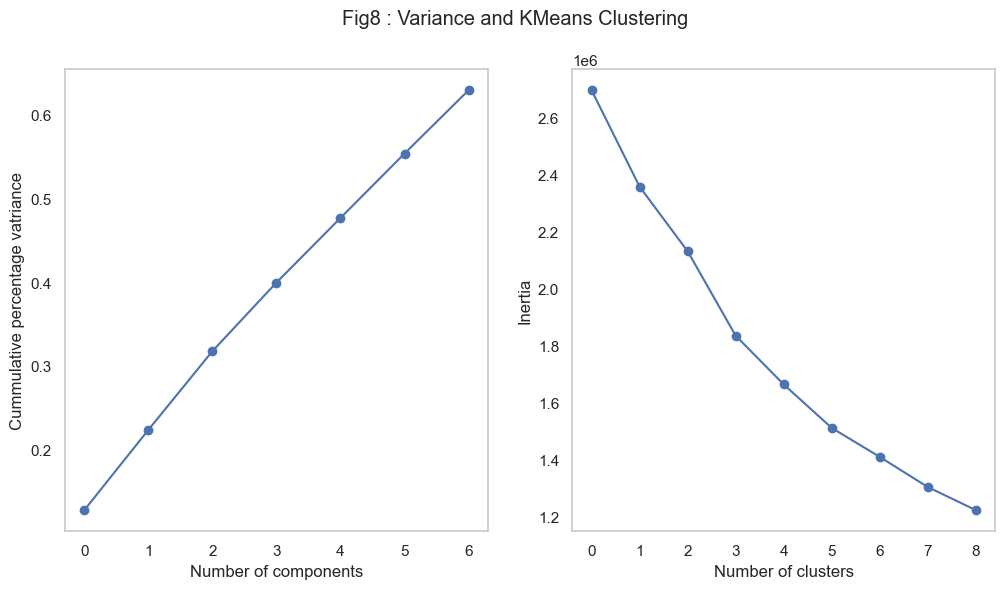

In [43]:

#scaler = StandardScaler()
#scaled_data = scaler.fit_transform(used_cars_encoded_df)

## Data is already scaled by the encode function above, so need to scale again
scaled_data = used_cars_encoded_df
#Since the data has 46 feature lets reduce the dimensions using PCA()
# We should find How many components we should have, for that we created the variance graph to find how many 
#components should be required to  capture 80%

pca = PCA(random_state=42)
pca.fit(scaled_data)
pca.explained_variance_ratio_

ratio = 0.7
pca_names = []
i = 0
# Lets select the components to capture 70 % variance
for cumratio in pca.explained_variance_ratio_.cumsum():
    if(0.7 < cumratio):
        break
    else:
        pca_names.append(f'pca{i}')
        i = i+1

#var_comp(pca.explained_variance_ratio_.cumsum(), 0.7)
pca = PCA(n_components=len(pca_names), random_state=42)

#fit the data
pca.fit(scaled_data)

#Calculate the component scores 
pca_scores = pca.transform(scaled_data)
inertia = []
for i in range(1,10):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_pca.fit(pca_scores)
    inertia.append(kmeans_pca.inertia_)

#Plot the variance 
fig, axs = plt.subplots(1,2, figsize=(12,6))

axs[0].plot(pca.explained_variance_ratio_.cumsum(), marker='o')
axs[0].set_xlabel('Number of components')
axs[0].set_ylabel('Cummulative percentage vatriance')
axs[0].grid()

#Lets plot the inertia data to fidn the num of clustets needed
axs[1].plot(inertia, marker='o')
axs[1].set_xlabel('Number of clusters')
axs[1].set_ylabel('Inertia')
axs[1].grid()


title, figcounter = cf.getFigTitle(figcounter,'Variance and KMeans Clustering')
fig.suptitle(title)
fig.savefig(images_path+title)
plt.show()


In [44]:
#predicted_clusters = DBSCAN(eps=3, min_samples=2).fit(used_cars_encoded_df)

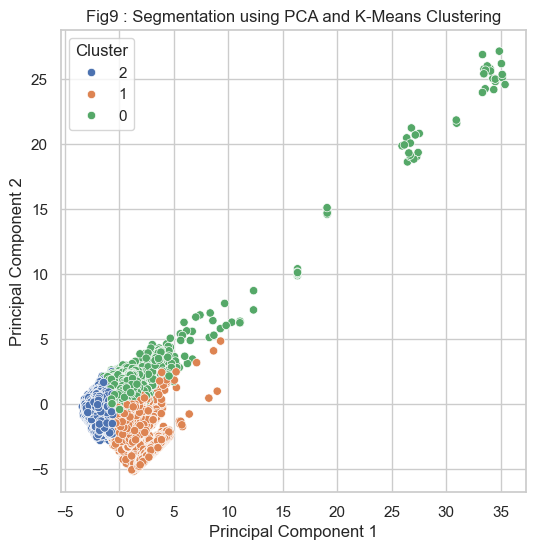

In [45]:
# We need 3 clusters 
kmeans_pca = KMeans(n_clusters=3 ,init='k-means++', random_state=42)
predicted_clusters= kmeans_pca.fit_predict(pca_scores)
df_pca_kmeans_clusters = pd.concat([used_cars_encoded_df.reset_index(drop=True), pd.DataFrame(data=pca_scores, columns=pca_names)], axis=1) 
df_pca_kmeans_clusters['clusters'] = predicted_clusters
# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'x': df_pca_kmeans_clusters.pca0,
    'y': df_pca_kmeans_clusters.pca1,
    'Cluster': predicted_clusters.astype(str)  # Convert cluster labels to strings for color encoding
})

# Create a scatter plot using Seaborn
plt.figure(figsize=(6, 6))
sns.scatterplot(data=plot_df, x='x', y='y', hue='Cluster')
title, figcounter = cf.getFigTitle(figcounter,'Segmentation using PCA and K-Means Clustering')
plt.title(title)
plt.savefig(images_path+title)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show();


In [46]:
used_cars_df_clusters = used_car_sliced_by_date_df
used_cars_df_encoded_clusters = used_cars_encoded_df

used_cars_df_clusters['clusters'] = predicted_clusters
used_cars_df_encoded_clusters['clusters'] = predicted_clusters
#print(used_cars_df_clusters.shape)
#print(used_cars_df_encoded_clusters.shape)


In [47]:
print(round(used_cars_df_clusters.groupby('clusters')['price'].mean()),0)
print(round(used_cars_df_clusters.groupby('clusters')['odometer'].mean()))

clusters
0    38741.0
1    20815.0
2    43369.0
Name: price, dtype: float64 0
clusters
0    101419.0
1     97896.0
2     40675.0
Name: odometer, dtype: float64


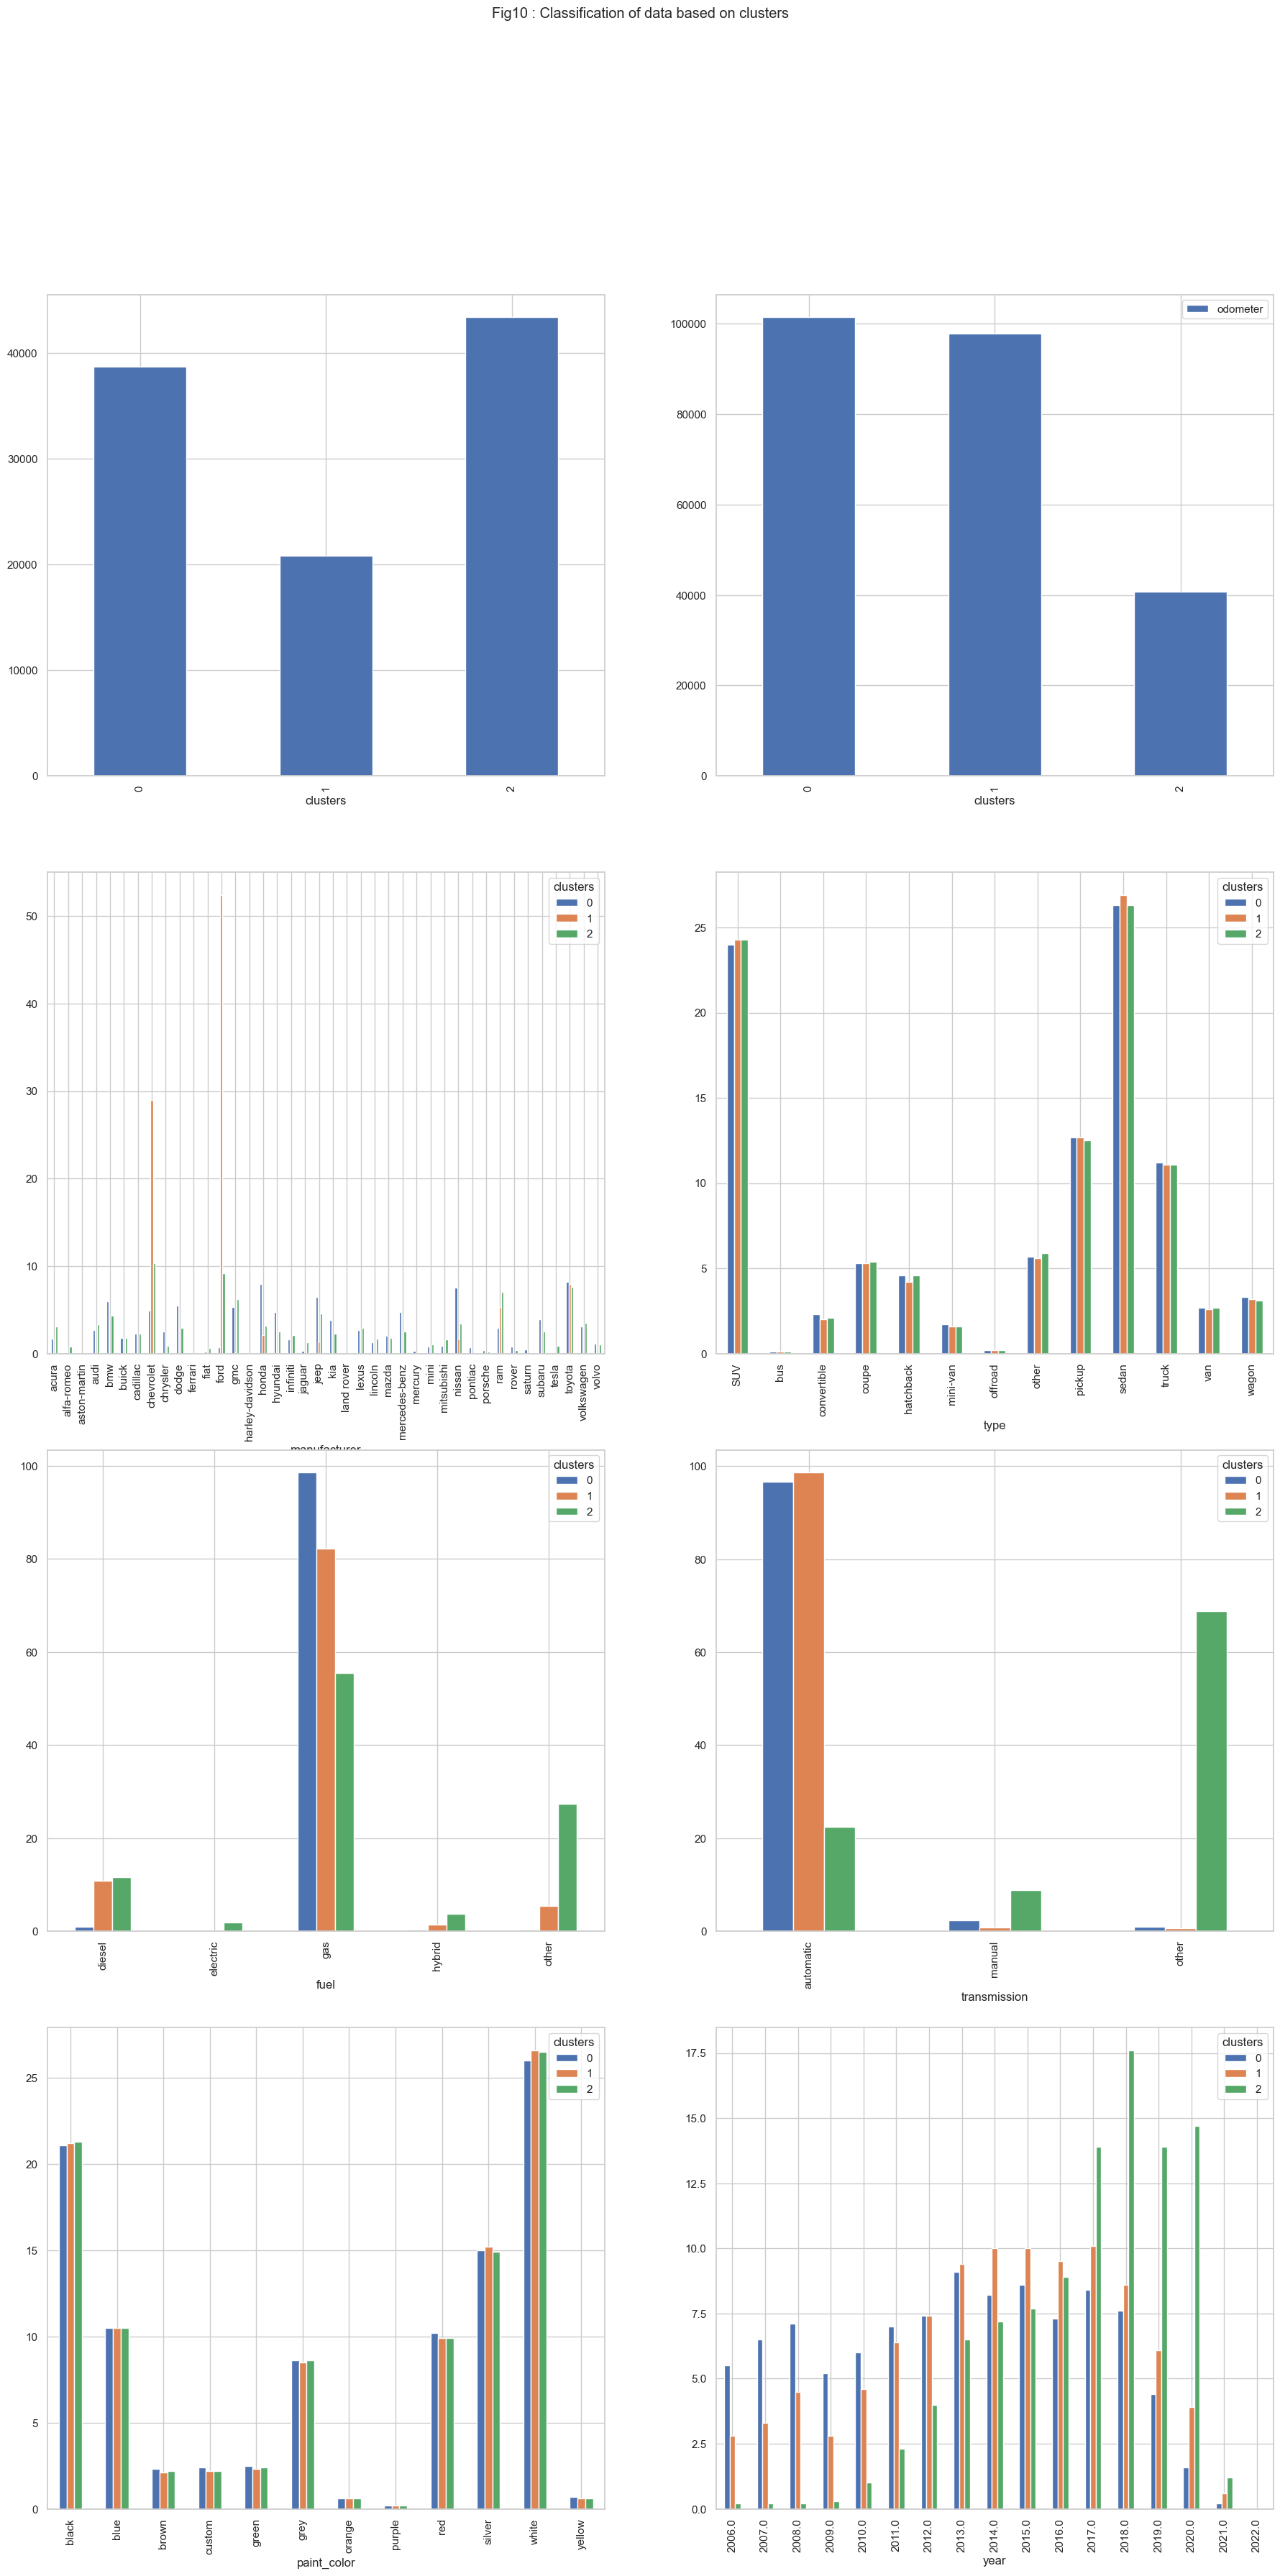

In [48]:
# Plotting of some metrics from classification

fig, axs = plt.subplots(4, 2)
fig.set_figheight(40)
fig.set_figwidth(22)
round(used_cars_df_clusters.groupby('clusters')['price'].mean()).plot.bar(ax=axs[0,0])
round(used_cars_df_clusters.groupby('clusters')[['odometer']].mean()).plot.bar(ax=axs[0,1])
used_cars_df_clusters.groupby('clusters')[['manufacturer']].value_counts(normalize=True).mul(100).round(1).unstack(0).plot.bar(ax=axs[1,0])
used_cars_df_clusters.groupby('clusters')[['type']].value_counts(normalize=True).mul(100).round(1).unstack(0).plot.bar(ax=axs[1,1])
used_cars_df_clusters.groupby('clusters')[['fuel']].value_counts(normalize=True).mul(100).round(1).unstack(0).plot.bar(ax=axs[2,0])
used_cars_df_clusters.groupby('clusters')[['transmission']].value_counts(normalize=True).mul(100).round(1).unstack(0).plot.bar(ax=axs[2,1])
used_cars_df_clusters.groupby('clusters')[['paint_color']].value_counts(normalize=True).mul(100).round(1).unstack(0).plot.bar(ax=axs[3,0])
used_cars_df_clusters.groupby('clusters')[['year']].value_counts(normalize=True).mul(100).round(1).unstack(0).plot.bar(ax=axs[3,1])
title, figcounter = cf.getFigTitle(figcounter,'Classification of data based on clusters')
fig.suptitle(title)
fig.savefig(images_path+title)
fig.show()


#### Cluster 0 - Medium Priced cars - Price Avg - $38K/High Milage
- odometer
    - 101 K
- Year
    - Sales have been declining in this category since 2017
- Fuel
    - Gas
- Manufacturer(Top Selllers)
    - Nissan
    - GMC
    - Toyota
    - Old Luxury
        - Benz
        - BMW 
- Title
    - Clean
- Transmission 
    - Automatic
- Type
    - Sedan
    - SUV
    - Pickup
    - Truck  
- Paint 
    - White
    - Black
    - Silver

#### Cluster 1 - Low Priced cars -  Avg - $20K/Medium Mileage
- Best Sellers  2013 - 2017
- odometer
    - 97 K
- Year
    - Sales have been declining in this category since 2017
- Fuel
    - Gas
    - Other
- Manufacturer
    - ford - ~55% of total sales
    - chevrolet - ~30%  of total sales
- Title
    - Clean
- Transmission 
    - Gas   
- Type - Sedan/SUV were 50% of sales
    - Sedan
    - SUV
    - Pickup  
- Paint 
    - White
    - Black
    - Silver
    - Blue
    - Red
    - Grey

#### Cluster 2 - High Priced - Price Avg - $40K/Low Mileage
- odometer
    - 40 K
- Year
    - Has been top sellers since 2017 > 
- Fuel
    - Gas
- Manufacturer
    - Toyota
    - GMC
    - BMW
    - Jeep
- Title
    - Clean
- Transmission 
    - Other
        - More than 70% of cars
    - Gas 
- Type
    - Sedan
    - SUV
- Paint 
    - White
    - Black
    - Silver


In [50]:
print(used_cars_df.manufacturer.unique().size)
print(used_cars_df.state.unique().size)
#print(used_cars_df.region.unique().size)
print(used_cars_df.model.unique().size)


41
51
21757


In [51]:
# Although the  model which can be important feature has 21769 unique values, so will drop for now
used_cars_df.drop(columns=['model'], inplace=True)

## Remove te clusters added by Classification/PCA 
used_car_sliced_by_date_df.drop(columns=['clusters'], inplace=True)

In [52]:
# We are close to 
print(used_cars_df.shape)


(385611, 12)


In [53]:
# After slice we still have 373K of data
print(used_car_sliced_by_date_df.shape)

(329569, 13)


#### Now we want to do basic correlation of Price to feature, this might help in feature selection and validate the results of out modeling to compare any hypothesis


In [55]:
used_cars_df_encoded = cf.count_encoder(used_car_sliced_by_date_df, cf.get_cat_features(used_car_sliced_by_date_df))
used_cars_df_encoded

,price,year,odometer,manufacturer,model,cylinders,fuel,title_status,transmission,drive,type,paint_color,state
0,-0.000207,-0.034521,-0.220392,-0.526798,-0.432672,0.034814,0.444822,0.178862,-1.832683,0.807714,0.803824,-0.787400,-0.888999
1,-0.001810,-1.056948,-0.113890,1.020097,3.004415,0.841348,0.444822,0.178862,-1.832683,-1.924591,-0.606367,1.227622,-0.888999
2,0.000667,1.499120,-0.530653,1.020097,-0.220272,0.034814,0.444822,0.178862,-1.832683,0.046290,1.055138,1.227622,-0.888999
3,-0.000586,0.732299,-0.354852,0.160555,-0.356932,0.841348,0.444822,0.178862,-1.832683,0.046290,0.803824,1.227622,-0.888999
4,-0.002916,-0.290128,0.340508,1.747128,-0.269667,-0.811498,0.444822,0.178862,0.515605,0.807714,-0.606367,0.581506,-0.888999
...,...,...,...,...,...,...,...,...,...,...,...,...,...
329564,-0.001664,1.243513,-0.426072,-0.385192,-0.601439,0.034814,0.444822,0.178862,-1.832683,0.046290,1.055138,0.581506,-1.229379
329565,-0.000644,1.499120,-0.587730,-1.124131,-0.575095,-0.811498,0.444822,0.178862,-1.832683,0.807714,-0.606367,-0.849554,-1.229379
329566,-0.000003,1.499120,-0.650602,-0.958275,-0.316593,0.841348,-2.264564,0.178862,-1.832683,0.046290,-1.527335,-0.787400,-1.229379
329567,-0.000877,0.987906,-0.442993,-0.904360,-0.470542,0.841348,0.444822,0.178862,-1.832683,0.046290,-1.582868,1.227622,-1.229379


In [56]:
price_corr = used_cars_df_encoded.corrwith(used_cars_df_encoded["price"]).sort_values(ascending=False)
price_corr.head(50)
#sns.heatmap(used_cars_df_encoded, annot=True, cmap= 'Blues')


price           1.000000
drive           0.001261
odometer        0.001083
title_status    0.000513
model           0.000031
type           -0.000150
manufacturer   -0.000166
state          -0.000531
paint_color    -0.000596
transmission   -0.000879
fuel           -0.000978
cylinders      -0.001376
year           -0.003167
dtype: float64

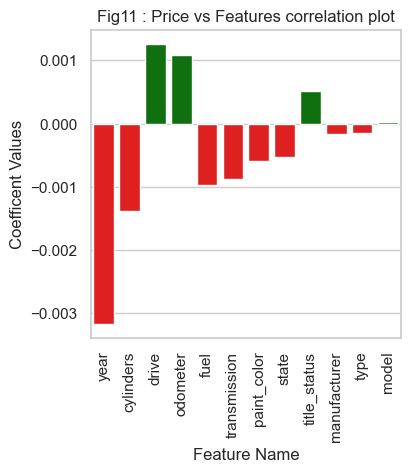

In [57]:
# Plot coef
plot_price_corr_df = pd.DataFrame(price_corr.drop('price'), columns=['corrcoefs']).reset_index()
plot_price_corr_df = plot_price_corr_df.rename({'index':'feature'}, axis='columns')
plot_price_corr_df['abs_corr'] = plot_price_corr_df['corrcoefs'].apply(lambda x: abs(x))
plot_price_corr_df['colors'] = plot_price_corr_df['corrcoefs'].apply(lambda x: "green" if x > 0 else "red")
plot_price_corr_df = plot_price_corr_df.sort_values("abs_corr", ascending=False).reset_index()
plot_price_corr_df

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.barplot(x='feature',
            y='corrcoefs',
            data=plot_price_corr_df, palette=np.array(plot_price_corr_df['colors']))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
title, figcounter = cf.getFigTitle(figcounter,'Price vs Features correlation plot')
ax.set_title(title)
ax.set_ylabel('Coefficent Values')
ax.set_xlabel('Feature Name')
fig.savefig(images_path+title)
fig.show()


In [58]:
#used_cars_df_encoded.to_csv('data_encoded.csv')

#### Intersting observation but different from above correlation, price seems to be +ve correlation to 
- Odometer
- type - We have seen Truck/Pickup are best sellers, so understood
- transmission
- title_status

These findings are different from what we interpreted from classification, were expecting
- manufacturer
- year - Strong -ve correlated - Does it older the vehicle, will have lot of miles on vehicle 
- paint_color - Color is not a choice factor to a whole lot
- state - Where you sell does not matter

#### But one thing we can interpret that features that should be included
- odometer
- type
- transmission


#### Before we get to run in pipeline, wanted to run a Linear Regression model(totally unnecessary)
- We need to encode
- Scale
- Predict using LinearRegression and capture MSE/Score. This will act as baseline before we run multiple pipelines
- We gona start with 11 features ( too high ????? )

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [62]:
## Lets go to modeling now
X,y = cf.getX_Y(used_car_sliced_by_date_df)
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train.shape = ', X_train.shape)
print('X_test.shape  = ', X_test.shape)

(329569, 12)
X_train.shape =  (230698, 12)
X_test.shape  =  (98871, 12)


In [63]:
linreg = LinearRegression(fit_intercept=False)
X_train_encoded = cf.count_encoder(X_train, cf.get_cat_features(X_train))
X_test_encoded = cf.count_encoder(X_test, cf.get_cat_features(X_test))
linreg.fit(X_train_encoded, y_train)
print('Train MSE : ', round(mean_squared_error(y_train, linreg.predict(X_train_encoded)), 4)) 
print('Test MSE : ', round(mean_squared_error(y_test, linreg.predict(X_test_encoded)), 4)) 
print('Train Score ', linreg.score(X_train_encoded, y_train))
print('Test Score ', linreg.score(X_test_encoded, y_test))
print(linreg.coef_)
print(linreg.get_params(deep=True))

#plt.scatter(used_cars_df_encoded, x='odometer', y='price')

Train MSE :  67283826969603.945
Test MSE :  3459440817.2941
Train Score  3.1071453926445614e-06
Test Score  -3.5603911212701718
[-38025.48389939   2471.44147824  -3112.63639059   3934.61543707
 -13913.55783591 -10551.39098915   4228.70936245 -14897.5540997
  13193.0145955   -1700.17132027  -5986.88675453  -4990.91779304]
{'copy_X': True, 'fit_intercept': False, 'n_jobs': None, 'positive': False}


#### Quick observation looks like overfitted model, but we have not done much
Test MSE is way higher than Train and score is negative

# Model Pipleline Prep

#### Pretty Intersting 
- If Data is sliced and used after 2012, when we had real big sales over 20K per year, the basic correlation of price starts to correlate with Year, manufacturer and title
- If Data is used starting 2001, the odometer is top correlation, title_status, model

### Big Question should we training data into multiple sets for better training the model ... If we have time we should try this too 

### for now we will start with 2012. 

#### NOTE : Logs
##### With Data sliced from 2001-01-01, we are seeing pathetic results looks like basic linear model is overfitten 
- maybe due to too many, and the sales data is skewe very higly since 2006, so may be slice from there and see if the model comes out better
    - Alpha is very high 10000000000.0 
- Still pretty bad, will remove some feature, PCA test showed 7 components so will try with that
  -  Feature selectiom showed only 2 features  - ['odometer', 'transmission']
    - Dropping state, manufacturer, paint_color, title_status
        - Feature selectiom showed only 2 features  - ['fuel', 'transmission']
    - Dropping fuel and tranmission, we have price, year, cycliners, odometer, drive, type
    - Now will move the time window to 2010
        - Atlest +ve test scores now
            - sel-fc(2)-al(4832.93)-ho	7.837769e+10	8.242088e+08	0.000557	0.049026
        - Let change time window to 2012
            - Better Test score is only 13% 
            - sel-fc(2)-al(4832.93)-ho	8.926477e+10	2.237183e+08	0.000367	0.138581
                - year      0.235  +/- 0.002
                - odometer  0.006  +/- 0.000
        - Should try time window from 2014 - 2020
            -  sel-fc(2)-al(4832.93)-kfold	1.119317e+11	2.609461e+08	0.000166	0.081093
               -  ['drive', 'type']
               - year      0.235  +/- 0.002
               - odometer  0.006  +/- 0.000
        - Bringing back all features and resetting timeline to 2012-01-01.Score upto 18%
            -  sel-fc(7)-al(16237.77)-kfold	8.925050e+10	2.106700e+08	0.000527	0.188823
            - ['year', 'cylinders', 'fuel', 'odometer', 'type', 'paint_color', 'state']
            - year      0.195  +/- 0.002
            - fuel      0.053  +/- 0.001
            - manufacturer  0.020  +/- 0.001
            - transmission  0.013  +/- 0.000
            - odometer  0.007  +/- 0.000
            - title_status  0.005  +/- 0.000
            - state     0.003  +/- 0.000

 
  

In [68]:
# We are close to 385 K records
data_sales_since = '2012-01-01'

#dropped_features = ['state', 'manufacturer', 'paint_color', 'title_status', 'fuel', 'transmission']
dropped_features = []
model_df = used_cars_df.drop(columns=dropped_features).reset_index()
model_df.index = pd.to_datetime(manu_df.year, format='%Y')
used_car_sliced_by_date_df = model_df[data_sales_since:]
used_car_sliced_by_date_df.index = used_car_sliced_by_date_df['index']
used_car_sliced_by_date_df.drop(columns='index', inplace=True)

In [69]:

X,y = cf.getX_Y(used_car_sliced_by_date_df)
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train.shape = ', X_train.shape)
print('X_test.shape  = ', X_test.shape)


(245275, 11)
X_train.shape =  (171692, 11)
X_test.shape  =  (73583, 11)


In [70]:
## Globals

models = []
train_mses= []
test_mses = []
train_scores = []
test_scores = []
train_perms = []
test_perms = []
model_coefs = []
results = []

hyper_param_alpha = {'model__alpha': np.logspace(0, 10, 20)}
max_feature_search = 6 if (len(X.columns) > 6) else len(X.columns) 
##Commenting search across all feature count select, this take a lot of time, so lets fix it to max 10
hyper_param_fs = {'selector__n_features_to_select': np.linspace(2,max_feature_search, num=(max_feature_search - 1)).astype('int')}
###yper_param_fs = {'selector__n_features_to_select': [2,3,4,5,6,7]}

#### Common Functions for Pipelines

#### Approach
For every model approach capture
- MSE
- Score
- Coefficents
  
1. Linear Regression() - 
    - Start with basic regression pipeline
    - Use Ridge()
        - gridSearch for the best alpha
    - Lasso()
    - SequentialFeatureSelector with and without Lasso()
        - Find hyperparam - n_features_to_select 
    - Find and run pipeline with best hyperparams
        - alpha
        - n_features_to_select
        - Capture coefficents
1. Polynomial Feature Transformation 
    - GridSearch for best degree   
    - Use Ridge()
        - gridSearch for the best alpha
    - SequentialFeatureSelector with and without Lasso()
    - Find and run pipeline with best hyperparams
        - degree
        - alpha
        - n_features_to_select
        - Capture coefficents

Plot the MSE's and make recommendation

### Pipelines Encoder/Transformers

In [74]:
categorical_features = cf.get_cat_features(used_car_sliced_by_date_df)
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(sparse_output=False)),
    ]
)

count_categorical_transformer = Pipeline(
    
    steps=[
        ("encoder", ce.CountEncoder()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", count_categorical_transformer, categorical_features),
    ], remainder='passthrough'
)

poly_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", count_categorical_transformer, categorical_features),
        ("poly", PolynomialFeatures(include_bias = False), make_column_selector(dtype_include=np.number)),
    ], remainder='passthrough')


In [75]:
## Common functions for Pipeline Processing

rs = 42
RS = 42
models = []
train_mses= []
test_mses = []
train_scores = []
test_scores = []
train_perms = []
test_perms = []
model_coefs = []
results = []

def reset_globals():
    models = []
    train_mses= []
    test_mses = []
    train_scores = []
    test_scores = []
    train_perms = []
    test_perms = []
    model_coefs = []
    results = []
    print('Models = ', models)
    print('Result = ', results)


def dump_df():
    df = {}
    df['Models'] = models
    df['Train MSE'] = train_mses
    df['Test MSE'] = test_mses
    df['Train Score'] = train_scores
    df['Test Score'] = test_scores
    return pd.DataFrame.from_dict(df)

def dump_results():
    cols = ['model', 'train_mse', 'test_mse', 'train_score', 'test_score']
    return pd.DataFrame.from_dict(results)

def dump_coefs_df(model_coefs):
    return pd.DataFrame(model_coefs, columns=X_train.columns, index=models)

def pipeline_proces_and_holdout(pipe, model_name):
    print(f'==================== RUNNING {model_name}=================================')
    models.append(f'{model_name}-ho')
    pipe.fit(X_train, y_train)
    train_mse = round(mean_squared_error(y_train, pipe.predict(X_train)), 5)
    train_mses.append(train_mse)
    test_mse = round(mean_squared_error(y_test, pipe.predict(X_test)), 5)
    test_mses.append(test_mse)
    train_score = pipe.score(X_train, y_train)
    train_scores.append(train_score)
    test_score = pipe.score(X_test, y_test)
    test_scores.append(test_score)
    result = {'model' :f'{model_name}-ho', 'train_mse' : train_mse, 'test_mse' : test_mse, 'train_score' :train_score, 'test_score' :test_score}
    print(result)
    results.append(result)
    print(pipe.named_steps['model'].coef_)
    model_coefs.append(pipe.named_steps['model'].coef_)
    print('==================== DONE =================================================')

def pipeline_proces_and_kfold(pipe, model_name):
    print(f'==================== RUNNING {model_name}=================================')
    models.append(f'{model_name}-kfold')
    kfold = KFold(n_splits=3, random_state=42, shuffle=True)
    selector_grid = GridSearchCV(pipe, {}, scoring='r2', cv=kfold, verbose=2)
    selector_grid.fit(X_train, y_train)
    best_estimator = selector_grid.best_estimator_
    best_model = selector_grid.best_estimator_.named_steps['model']
    train_mse = round(mean_squared_error(y_train, best_estimator.predict(X_train)), 5)
    train_mses.append(train_mse)
    test_mse = round(mean_squared_error(y_test, best_estimator.predict(X_test)), 5)
    test_mses.append(test_mse)
    train_score = best_estimator.score(X_train, y_train)
    train_scores.append(train_score)
    test_score = best_estimator.score(X_test, y_test)
    test_scores.append(test_score)
    
#    test_scores.append(list(selector.cv_results_.get('mean_test_score'))[0])
    result = {'model' :f'{model_name}-kfold', 'train_mse' : train_mse, 'test_mse' : test_mse, 'train_score' :train_score, 'test_score' :test_score}
    print(result)
    results.append(result)
    print('=====================================================================')
    return selector_grid

def grid_search_for_best_stuff(pipe, params, X, y):
    selector_grid = GridSearchCV(pipe, param_grid=params, verbose=2)
    selector_grid.fit(X, y)
    selector_grid.cv_results_
    best_estimator = selector_grid.best_estimator_
    best_model = selector_grid.best_estimator_.named_steps['model']
    return selector_grid, best_estimator, best_model, selector_grid.best_estimator_.get_params()

def gs_for_number_of_features(pipe, feature_select):
    grid, best_estimator, best_model, params = grid_search_for_best_stuff(pipe, feature_select, X_train, y_train)
    best_feature_count = params.get('n_features_to_select')
    print('best_n_features_to_select = ',best_feature_count)
    pipe.set_params(selector__n_features_to_select=best_feature_count)
    pipeline_proces_and_holdout(pipe, f'select_fcount-{best_feature_count}')
    return grid, best_estimator, best_model, params

def gs_for_best_alpha(pipe, ridge_param_dict):
    print('=========== Searching for best alpha ====================')
    grid, best_estimator, best_model, params = grid_search_for_best_stuff(pipe, ridge_param_dict, X_train, y_train)
    best_alpha = round(params.get('model__alpha'),2)
    print('best_alpha = ',best_alpha)
    pipe.set_params(model__alpha=best_alpha)
    pipeline_proces_and_holdout(pipe, f'best_alpha-{best_alpha}')
    return best_alpha

def getColumnNames(fromName, encoded_names):
    arr = []
    for i in range(0, fnames.size):
        arr.append(X_train.columns[int(fnames[i][1:])])
    return arr

def dump_hyper_params(hyper_params, best_model_params):
    for hp in hyper_params:
        print(f'{hp}={best_model_params.get(hp)}')
        return best_model_params.get(hp)

def selected_columns_list(cols_arr ,selected_list):
    selected_columns = []
    for i in  range(len(cols_arr)):
        if(selected_list[i]):
            selected_columns.append(cols_arr[i])
    return selected_columns

def dump_feature_imp(pipeline):
    r = permutation_importance(pipeline, X_test, y_test, random_state=42, n_repeats=30, scoring='r2')
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"{X.columns[i]:<18}  "
            f"{r.importances_mean[i]:.3f} "
            f" +/- {r.importances_std[i]:.3f}")

def pipeline_factory(transformer):
    linear = Pipeline([
        ('transformer',  transformer),
        ('scaler', StandardScaler()),
        ('model', LinearRegression(fit_intercept=False) )
    ])

    ridge = Pipeline([
        ('transformer',  transformer),
        ('scaler', StandardScaler()),
        ('model', Ridge() )
    ])

    lasso = Pipeline([
        ('transformer',  transformer),
        ('scaler', StandardScaler()),
        ('model', Lasso(random_state=rs) )
    ])

    fs = Pipeline([
        ('transformer',  transformer),
        ('scaler', StandardScaler()),
        ('selector', SequentialFeatureSelector(LinearRegression(fit_intercept=False))),
        ('model', LinearRegression() )
    ])

    fs_l = Pipeline([
        ('transformer',  transformer),
        ('scaler', StandardScaler()),
        ('selector', SequentialFeatureSelector(Lasso(random_state=42))),
        ('model', LinearRegression() )
    ])
    
    complex = Pipeline([
        ('transformer',  transformer),
        ('scaler', StandardScaler()),
        ('selector', SequentialFeatureSelector(Lasso(random_state=42))),
        ('model', Ridge(random_state=rs))
    ])
    
    ms = Pipeline([
        ('transformer',  transformer),
        ('scaler', StandardScaler()),
        ('selector', SelectFromModel(Lasso(random_state=rs))),
        ('model', LinearRegression() )
    ])
    return linear, ridge, lasso, fs, complex, ms, fs_l


In [76]:
reset_globals()
### Linear
linear, ridge, lasso, fs, complex, ms, fs_l  = pipeline_factory(preprocessor)
pipeline_proces_and_holdout(linear, 'linear')
pipeline_proces_and_holdout(ridge, 'ridge')
pipeline_proces_and_holdout(lasso, 'lasso')
best_alpha = gs_for_best_alpha(ridge , hyper_param_alpha)
pipeline_proces_and_holdout(fs, 'afs-fwd')
fs.set_params(selector__direction='backward')
pipeline_proces_and_holdout(fs, 'afs-bwd')

#Search for feature count
hyper_params = hyper_param_fs
complex.set_params(model__alpha=best_alpha)
grid, best_estimator, best_model, params = grid_search_for_best_stuff(complex, hyper_params, X_train, y_train)
feature_count = dump_hyper_params(hyper_params, params)

# We have multiple hyper params - alpha, features
# The best estimator should have  features were set as part of last search, set alpha and run

best_estimator.set_params(model__alpha=best_alpha)
pipeline_proces_and_holdout(best_estimator, f'sel-fc({feature_count})-al({best_alpha})')
abc = pipeline_proces_and_kfold(best_estimator, f'sel-fc({feature_count})-al({best_alpha})')

Models =  []
Result =  []
==================== RUNNING linear=================================
{'model': 'linear-ho', 'train_mse': 89777560636.04266, 'test_mse': 710087760.69299, 'train_score': -0.005375639957395872, 'test_score': -1.7341655854373723}
[ 2107.09541114  -648.12116687 -2540.0114745    928.51258807
 -1092.43301364 -1268.27828165  -189.93590953   726.22217047
  -738.74353822  5090.05225862  -925.16848789]
==================== DONE =================================================
==================== RUNNING ridge=================================
{'model': 'ridge-ho', 'train_mse': 89247359181.34561, 'test_mse': 213192449.41685, 'train_score': 0.0005618306426727893, 'test_score': 0.17911068104907935}
[ 2107.08277294  -648.11785282 -2539.99921112   928.50865131
 -1092.43315607 -1268.27116521  -189.93619467   726.21822808
  -738.7392067   5090.02243164  -925.17027411]
==================== DONE =================================================
==================== RUNNING lasso

In [77]:
results_df = dump_results()
results_df

,model,train_mse,test_mse,train_score,test_score
0,linear-ho,8.977756e+10,7.100878e+08,-0.005376,-1.734166
1,ridge-ho,8.924736e+10,2.131924e+08,0.000562,0.179111
2,lasso-ho,8.924736e+10,2.131860e+08,0.000562,0.179135
3,best_alpha-16237.77-ho,8.924765e+10,2.131418e+08,0.000559,0.179306
4,afs-fwd-ho,8.925152e+10,2.112870e+08,0.000515,0.186447
5,afs-bwd-ho,8.925152e+10,2.112870e+08,0.000515,0.186447
6,sel-fc(6)-al(16237.77)-ho,8.925103e+10,2.110824e+08,0.000521,0.187235
7,sel-fc(6)-al(16237.77)-kfold,8.925103e+10,2.110824e+08,0.000521,0.187235


In [78]:
feature_selected_list = selected_columns_list(X_train.columns, best_estimator.named_steps['selector'].get_support())
print(feature_selected_list)
coefs_arr = []
coefs_arr.append(best_estimator.named_steps['model'].coef_)
pd.DataFrame(coefs_arr, columns=feature_selected_list).head()
dump_feature_imp(best_estimator)

['year', 'cylinders', 'fuel', 'odometer', 'paint_color', 'state']
year                0.195  +/- 0.002
fuel                0.052  +/- 0.001
manufacturer        0.021  +/- 0.001
transmission        0.013  +/- 0.000
odometer            0.007  +/- 0.000
title_status        0.005  +/- 0.000


In [79]:
pd.DataFrame(coefs_arr, columns=feature_selected_list).head()

,year,cylinders,fuel,odometer,paint_color,state
0,1933.031409,-2338.193029,858.644657,-1105.058158,4655.621192,-930.879759


In [80]:
## Polynomial
plinear, pridge, plasso, pfs, pcomplex, pms, pfs_l  = pipeline_factory(poly_preprocessor)
hyper_params = {'transformer__poly__degree': [2,3,4]}
grid, poly_best_estimator, best_model, params = grid_search_for_best_stuff(plinear, hyper_params, X_train, y_train)
poly_degree = dump_hyper_params(hyper_params, params)
plinear.set_params(transformer__poly__degree=poly_degree)
pridge.set_params(transformer__poly__degree=poly_degree)
plasso.set_params(transformer__poly__degree=poly_degree)
pfs.set_params(transformer__poly__degree=poly_degree)
#pipeline_proces_and_holdout(linear, f'polylinear-d{poly_degree}')
pipeline_proces_and_holdout(pridge, f'polyridge-d{poly_degree}')
pipeline_proces_and_holdout(plasso, f'polylasso-d{poly_degree}')
poly_best_alpha = gs_for_best_alpha(pridge , hyper_param_alpha)
pipeline_proces_and_holdout(pfs, f'poly-afs-fwd-d{poly_degree}')
pfs.set_params(selector__direction='backward')
pipeline_proces_and_holdout(pfs, f'poly-afs-bwd-d{poly_degree}')
pipeline_proces_and_holdout(pfs_l, f'poly-afs_l-fwd-d{poly_degree}')


#Search for feature count
hyper_params = hyper_param_fs
pcomplex.set_params(model__alpha=poly_best_alpha)
pcomplex.set_params(transformer__poly__degree=poly_degree)
grid, poly_best_estimator, best_model, params = grid_search_for_best_stuff(pcomplex, hyper_params, X_train, y_train)
feature_count = dump_hyper_params(hyper_params, params)

# We have multiple hyper params - alpha, features, degree
# The best estimator should have  degree already set(as part of complex run), features were set as part of last search
poly_best_estimator.set_params(model__alpha=best_alpha)
abc = pipeline_proces_and_holdout(poly_best_estimator, f'poly-sel-d{poly_degree}-fc({feature_count})-al({best_alpha})')


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ........................transformer__poly__degree=2; total time=   1.1s
[CV] END ........................transformer__poly__degree=2; total time=   1.0s
[CV] END ........................transformer__poly__degree=2; total time=   1.1s
[CV] END ........................transformer__poly__degree=2; total time=   1.1s
[CV] END ........................transformer__poly__degree=2; total time=   1.1s
[CV] END ........................transformer__poly__degree=3; total time=   1.2s
[CV] END ........................transformer__poly__degree=3; total time=   1.2s
[CV] END ........................transformer__poly__degree=3; total time=   1.1s
[CV] END ........................transformer__poly__degree=3; total time=   1.1s
[CV] END ........................transformer__poly__degree=3; total time=   1.2s
[CV] END ........................transformer__poly__degree=4; total time=   1.2s
[CV] END ........................transformer__pol

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [82]:
results_df = dump_results()
results_df

,model,train_mse,test_mse,train_score,test_score
0,linear-ho,8.977756e+10,7.100878e+08,-0.005376,-1.734166
1,ridge-ho,8.924736e+10,2.131924e+08,0.000562,0.179111
2,lasso-ho,8.924736e+10,2.131860e+08,0.000562,0.179135
3,best_alpha-16237.77-ho,8.924765e+10,2.131418e+08,0.000559,0.179306
4,afs-fwd-ho,8.925152e+10,2.112870e+08,0.000515,0.186447
5,afs-bwd-ho,8.925152e+10,2.112870e+08,0.000515,0.186447
6,sel-fc(6)-al(16237.77)-ho,8.925103e+10,2.110824e+08,0.000521,0.187235
7,sel-fc(6)-al(16237.77)-kfold,8.925103e+10,2.110824e+08,0.000521,0.187235
8,polyridge-d4-ho,8.924410e+10,2.109649e+08,0.000598,0.187688
9,polylasso-d4-ho,8.924436e+10,2.112065e+08,0.000595,0.186757


In [83]:
# Select the best configuration from the tests
results_df.sort_values('test_mse')

,model,train_mse,test_mse,train_score,test_score
11,poly-afs-fwd-d4-ho,8.924696e+10,2.080287e+08,0.000566,0.198993
13,poly-afs_l-fwd-d4-ho,8.924696e+10,2.080572e+08,0.000566,0.198884
8,polyridge-d4-ho,8.924410e+10,2.109649e+08,0.000598,0.187688
14,poly-sel-d4-fc(6)-al(16237.77)-ho,8.925103e+10,2.110698e+08,0.000521,0.187284
6,sel-fc(6)-al(16237.77)-ho,8.925103e+10,2.110824e+08,0.000521,0.187235
7,sel-fc(6)-al(16237.77)-kfold,8.925103e+10,2.110824e+08,0.000521,0.187235
9,polylasso-d4-ho,8.924436e+10,2.112065e+08,0.000595,0.186757
4,afs-fwd-ho,8.925152e+10,2.112870e+08,0.000515,0.186447
5,afs-bwd-ho,8.925152e+10,2.112870e+08,0.000515,0.186447
10,best_alpha-54555.95-ho,8.924693e+10,2.115814e+08,0.000567,0.185314


In [84]:
### Lets plot the MSE to choose the best model
#### For plotting removing row 0 form results data, since MSE is too high and it does not show variance in test results
resulting_df = results_df.drop(axis=0, index=0).reset_index().drop('index', axis=1).sort_values('test_mse')
resulting_df

,model,train_mse,test_mse,train_score,test_score
10,poly-afs-fwd-d4-ho,8.924696e+10,2.080287e+08,0.000566,0.198993
12,poly-afs_l-fwd-d4-ho,8.924696e+10,2.080572e+08,0.000566,0.198884
7,polyridge-d4-ho,8.924410e+10,2.109649e+08,0.000598,0.187688
13,poly-sel-d4-fc(6)-al(16237.77)-ho,8.925103e+10,2.110698e+08,0.000521,0.187284
5,sel-fc(6)-al(16237.77)-ho,8.925103e+10,2.110824e+08,0.000521,0.187235
6,sel-fc(6)-al(16237.77)-kfold,8.925103e+10,2.110824e+08,0.000521,0.187235
8,polylasso-d4-ho,8.924436e+10,2.112065e+08,0.000595,0.186757
3,afs-fwd-ho,8.925152e+10,2.112870e+08,0.000515,0.186447
4,afs-bwd-ho,8.925152e+10,2.112870e+08,0.000515,0.186447
9,best_alpha-54555.95-ho,8.924693e+10,2.115814e+08,0.000567,0.185314


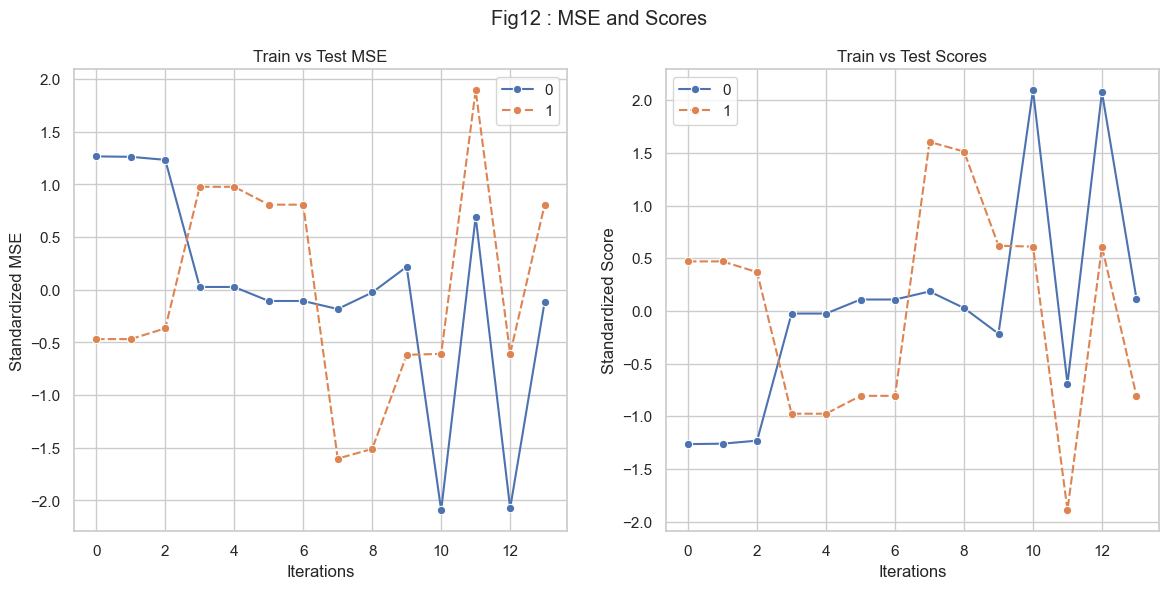

In [85]:
### Lets plot the MSE to choose the best model
#### For plotting removing row 0 form results data, since MSE is too high and it does not show variance in test results
resulting_df = results_df.drop(axis=0, index=0).reset_index()

fig, axs = plt.subplots(1, 2)
fig.set_figheight(6)
fig.set_figwidth(14)
sns.set_theme(style="whitegrid")
sns.lineplot(StandardScaler().fit_transform(resulting_df[['test_mse','train_mse']]), markers='o', ax=axs[0])
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Standardized MSE')
axs[0].set_title('Train vs Test MSE')
#plt.legend(labels=["A", "B"])
sns.lineplot(StandardScaler().fit_transform(resulting_df[['test_score','train_score']]), markers='o',ax=axs[1])
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Standardized Score')
axs[1].set_title('Train vs Test Scores')
title, figcounter = cf.getFigTitle(figcounter,'MSE and Scores')
fig.suptitle(title)
fig.savefig(images_path+title)
fig.show()



In [86]:
## The lowest MSE was for iteration 10 -'poly-afs-bwd-d2-ho'
# Let's reun and get coeficients and selected feature and importance

pfs.set_params(transformer__poly__degree=poly_degree)
pfs.set_params(selector__direction='forward')
pipeline_proces_and_holdout(pfs, f'poly-afs-fwd-d{poly_degree}')

pcoefs_arr = []
pcoefs_arr.append(pfs.named_steps['model'].coef_)
dump_feature_imp(pfs)

==================== RUNNING poly-afs-fwd-d4=================================
{'model': 'poly-afs-fwd-d4-ho', 'train_mse': 89246956394.02327, 'test_mse': 208028702.25811, 'train_score': 0.0005663412638026166, 'test_score': 0.1989934906887708}
[  2301.24745378  -2617.58951339   1003.04705063   -570.36566018
   -755.92102427  49391.59240161   3777.35595399 -56537.82339998
  33428.90365503 -54765.75330279  27534.76947612]
==================== DONE =================================================
year                0.117  +/- 0.001
odometer            0.060  +/- 0.001
fuel                0.060  +/- 0.001
manufacturer        0.028  +/- 0.001
title_status        0.006  +/- 0.000
transmission        0.004  +/- 0.000
state               0.004  +/- 0.000


In [87]:
#pd.DataFrame(coefs_arr, columns=fs.named_steps['selector'].get_feature_names_out()).head()
all_cols = selected_columns_list(pfs.named_steps['transformer'].get_feature_names_out(), pfs.named_steps['selector'].get_support())
pcoeff_df = pd.DataFrame(pcoefs_arr, columns=all_cols,index=['coefficents']).T
pcoeff_df

,coefficents
cat__manufacturer,2301.247454
cat__fuel,-2617.589513
cat__title_status,1003.047051
cat__transmission,-570.365660
cat__state,-755.921024
poly__year^2 odometer,49391.592402
poly__year^4,3777.355954
poly__year^3 odometer,-56537.823400
poly__year^2 odometer^2,33428.903655
poly__year odometer^3,-54765.753303


In [88]:
plot_coefs_df = pcoeff_df.reset_index()
plot_coefs_df = plot_coefs_df.rename({'index':'feature'}, axis='columns')
plot_coefs_df['abs_coef'] = plot_coefs_df['coefficents'].apply(lambda x: abs(x))
plot_coefs_df['colors'] = plot_coefs_df['coefficents'].apply(lambda x: "green" if x > 0 else "red")
plot_coefs_df = plot_coefs_df.sort_values("abs_coef", ascending=False).reset_index()
plot_coefs_df

,index,feature,coefficents,abs_coef,colors
0,7,poly__year^3 odometer,-56537.823400,56537.823400,red
1,9,poly__year odometer^3,-54765.753303,54765.753303,red
2,5,poly__year^2 odometer,49391.592402,49391.592402,green
3,8,poly__year^2 odometer^2,33428.903655,33428.903655,green
4,10,poly__odometer^4,27534.769476,27534.769476,green
5,6,poly__year^4,3777.355954,3777.355954,green
6,1,cat__fuel,-2617.589513,2617.589513,red
7,0,cat__manufacturer,2301.247454,2301.247454,green
8,2,cat__title_status,1003.047051,1003.047051,green
9,4,cat__state,-755.921024,755.921024,red


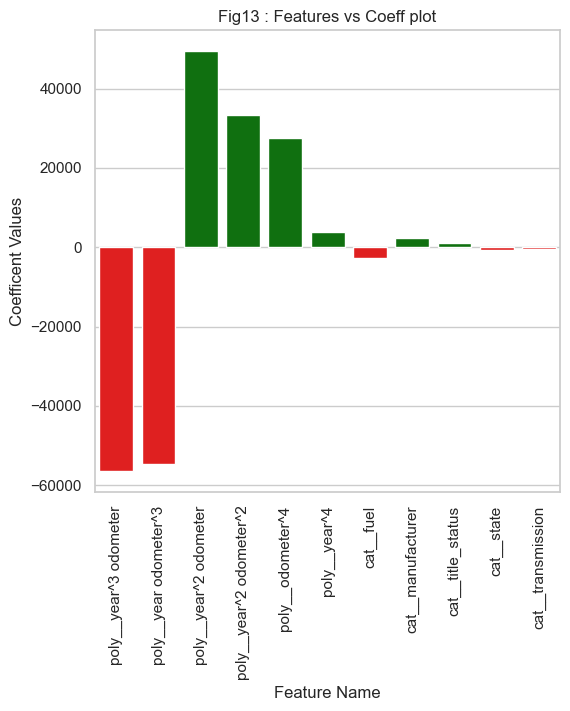

In [89]:
# Plot coef
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.barplot(x='feature',
            y='coefficents',
            data=plot_coefs_df, palette=np.array(plot_coefs_df['colors']))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
title, figcounter = cf.getFigTitle(figcounter,'Features vs Coeff plot')
ax.set_title(title)
ax.set_ylabel('Coefficent Values')
ax.set_xlabel('Feature Name')
fig.savefig(images_path+title)
fig.show()


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.